In [1]:
import os
import sys
import re
import json
import logging
import random
import torch
import swifter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from collections import Counter
from sklearn import metrics
logger = logging.getLogger(__name__)

In [2]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(sys.path[0]), '..', '..'))

In [3]:
def seed_everything(seed=914):
    logger.info(f"Global seed set to {seed}")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything()

# Load Data

Load json-format data into pandas DataFrame object.

In [4]:
with open(os.path.join(os.path.curdir, 'esaleshub.json')) as f:
    data_dump = json.loads(f.read())

In [5]:
df = pd.DataFrame(data_dump)
df

,datetime,call_time,label,class,known_truth,known_truth_class,transcript,client_dialogue,customer_dialogue
0,2021-12-01 03:33:52,412,4,appointment,4,Appointment/Booking,"[[""Client"", ""Thank you for calling Diner Rod p...",Thank you for calling Diner Rod partnered with...,Okay good morning Um We um I had a couple of e...
1,2021-12-01 06:09:38,580,4,appointment,4,Appointment/Booking,"[[""Client"", ""Thank you for calling Diner Rod p...",Thank you for calling Diner Rod partnered with...,Oh good morning Um Is it possible to book an e...
2,2021-12-01 07:08:54,264,0,unanswered_call,0,Unanswered Call,"[[""Client"", ""Thank you for calling Diner Rod p...",Thank you for calling Diner Rod partnered with...,hm Yeah Okay Okay Are you gonna have the table...
3,2021-12-01 07:17:36,359,4,appointment,4,Appointment/Booking,"[[""Client"", ""Thank you for calling Diner Rod p...",Thank you for calling Diner Rod partnered with...,Hi there Yeah I'd like to uh book an appointme...
4,2021-12-01 07:41:29,27,0,unanswered_call,0,Unanswered Call,"[[""Client"", ""Thank you for calling [PII] partn...",Thank you for calling [PII] partnered with bri...,None
...,...,...,...,...,...,...,...,...,...
13080,2021-12-31 22:51:30,463,6,general_customer_service,7,Chase Call,"[[""Client"", ""Thank you for calling Diner Rod p...",Thank you for calling Diner Rod partnered with...,um we booked an emergency plumber a few hours ...
13081,2021-12-31 22:55:59,661,6,general_customer_service,7,Chase Call,"[[""Customer"", ""it""],[""Client"", ""Thank""],[""Cust...",Thank you for calling Diner Rod partnered with...,it will happen It's an emergency line Yeah eme...
13082,2021-12-31 22:59:26,19,0,unanswered_call,0,Unanswered Call,"[[""Customer"", ""OKay""],[""Client"", ""Thank you fo...",Thank you for calling [PII] partnered with bri...,OKay
13083,2021-12-31 22:59:47,193,6,general_customer_service,6,General Customer Ser,"[[""Client"", ""Thank you for calling Diner Rod p...",Thank you for calling Diner Rod partnered with...,Hello Hi Um I was just on the call with your c...


## Label Correction

Loads of labels are improperly annotated. It will be broken down into 9 granular-level in this section.

 - `sales_call_lead`
 - `sales_call_qualified`
 - `sales_call_quote`
 - `sales_call_appointment`
 - `sales_call_sale`
 - `customer_service_call_chase`
 - `customer_service_call_general`
 - `customer_service_cancellation`
 - `external_call`

In [6]:
# Messy labels in the dataset
Counter(['{}-{}'.format(row[0], row[1]) for row in df[['known_truth', 'known_truth_class']].values])

Counter({'4-Appointment/Booking': 3087,
         '0-Unanswered Call': 4031,
         '3-Quote': 1472,
         '7-Chase Call': 1439,
         '6-General Customer Ser': 1939,
         '2-Qualified Lead': 570,
         '1-Lead': 381,
         '7-Recall': 22,
         '4-Appointment': 35,
         '13-Internal Call': 2,
         '1-Sales Lead': 26,
         '9-Cancellation': 22,
         '1-Sales L:ead': 1,
         '4-Appointmenr': 1,
         '14-External Call': 8,
         '0-Missed Call': 3,
         '0-Missed CXall': 1,
         '5-Sale': 40,
         '14-Exteral Call': 1,
         '10-Not Classified': 3,
         '8-Complaint': 1})

In [61]:
correct_mapping = {
    'Appointment/Booking': 'sales_call_appointment', 
    'Unanswered Call': 'unanswered_call', 
    'Quote': 'sales_call_quote', 
    'Chase Call': 'customer_service_call_chase', 
    'General Customer Ser': 'customer_service_call_general', 
    'Qualified Lead': 'sales_call_qualified', 
    'Lead': 'sales_call_lead', 
    'Recall': 'customer_service_call_chase', 
    'Appointment': 'sales_call_appointment', 
    'Internal Call': 'internal_call', 
    'Sales Lead': 'sales_call_lead', 
    'Cancellation': 'customer_service_call_cancellation', 
    'Sales L:ead': 'sales_call_lead', 
    'Appointmenr': 'sales_call_appointment', 
    'External Call': 'external_call', 
    'Missed Call': 'unanswered_call', 
    'Missed CXall': 'unanswered_call', 
    'Sale': 'sales_call_sale', 
    'Exteral Call': 'external_call', 
    'Not Classified': 'unclassified_call', 
    'Complaint': 'customer_service_call_general'
}

level2index = {
    'sales_call_lead': 0,
    'sales_call_qualified': 1,
    'sales_call_quote': 2,
    'sales_call_appointment': 3,
    'sales_call_sale': 4, 
    'customer_service_call_chase': 5,
    'customer_service_call_general': 6,
    'customer_service_call_cancellation': 7
}

In [62]:
df['level_3'] = df['known_truth_class'].map(correct_mapping)
df_clean = df[['datetime', 'transcript', 'client_dialogue', 'customer_dialogue', 'level_3']]
df_clean = df_clean.drop_duplicates(subset=['customer_dialogue'])
df_clean = df_clean.query(
    "level_3!='internal_call' & level_3!='unclassified_call' & level_3!='unanswered_call' & level_3!='external_call'"
)
df_clean = df_clean.reset_index(drop=True)
df_clean['level_3_id'] = df_clean['level_3'].map(level2index)
df_clean['dialogue'] = [d1 + d2 for d1, d2 in zip(df_clean['client_dialogue'], df_clean['customer_dialogue'])]

In [64]:
df_clean['level_2'] = df_clean['level_3'].apply(lambda x: 'sales_call' if x.startswith('sales') else 'customer_service_call')
df_clean['level_2_id'] = df_clean['level_2'].apply(lambda x: 0 if x.startswith('sales') else 1)

In [65]:
df_clean

,datetime,transcript,client_dialogue,customer_dialogue,level_3,level_3_id,dialogue,level_2,level_2_id
0,2021-12-01 03:33:52,"[[""Client"", ""Thank you for calling Diner Rod p...",Thank you for calling Diner Rod partnered with...,Okay good morning Um We um I had a couple of e...,sales_call_appointment,3,Thank you for calling Diner Rod partnered with...,sales_call,0
1,2021-12-01 06:09:38,"[[""Client"", ""Thank you for calling Diner Rod p...",Thank you for calling Diner Rod partnered with...,Oh good morning Um Is it possible to book an e...,sales_call_appointment,3,Thank you for calling Diner Rod partnered with...,sales_call,0
2,2021-12-01 07:17:36,"[[""Client"", ""Thank you for calling Diner Rod p...",Thank you for calling Diner Rod partnered with...,Hi there Yeah I'd like to uh book an appointme...,sales_call_appointment,3,Thank you for calling Diner Rod partnered with...,sales_call,0
3,2021-12-01 07:51:06,"[[""Client"", ""Thank you for calling Diner Rod p...",Thank you for calling Diner Rod partnered with...,I don't know Okay what kind of this credit car...,sales_call_appointment,3,Thank you for calling Diner Rod partnered with...,sales_call,0
4,2021-12-01 08:01:03,"[[""Client"", ""Thank you for calling Diner Rod p...",Thank you for calling Diner Rod partnered with...,good friend Just get a plumber for harvey at p...,sales_call_quote,2,Thank you for calling Diner Rod partnered with...,sales_call,0
...,...,...,...,...,...,...,...,...,...
8873,2021-12-31 21:35:50,"[[""Client"", ""Thank you for calling Diner Rod p...",Thank you for calling Diner Rod partnered with...,that's true One or two I don't know punish sur...,sales_call_quote,2,Thank you for calling Diner Rod partnered with...,sales_call,0
8874,2021-12-31 22:51:30,"[[""Client"", ""Thank you for calling Diner Rod p...",Thank you for calling Diner Rod partnered with...,um we booked an emergency plumber a few hours ...,customer_service_call_chase,5,Thank you for calling Diner Rod partnered with...,customer_service_call,1
8875,2021-12-31 22:55:59,"[[""Customer"", ""it""],[""Client"", ""Thank""],[""Cust...",Thank you for calling Diner Rod partnered with...,it will happen It's an emergency line Yeah eme...,customer_service_call_chase,5,Thank you for calling Diner Rod partnered with...,customer_service_call,1
8876,2021-12-31 22:59:47,"[[""Client"", ""Thank you for calling Diner Rod p...",Thank you for calling Diner Rod partnered with...,Hello Hi Um I was just on the call with your c...,customer_service_call_general,6,Thank you for calling Diner Rod partnered with...,customer_service_call,1


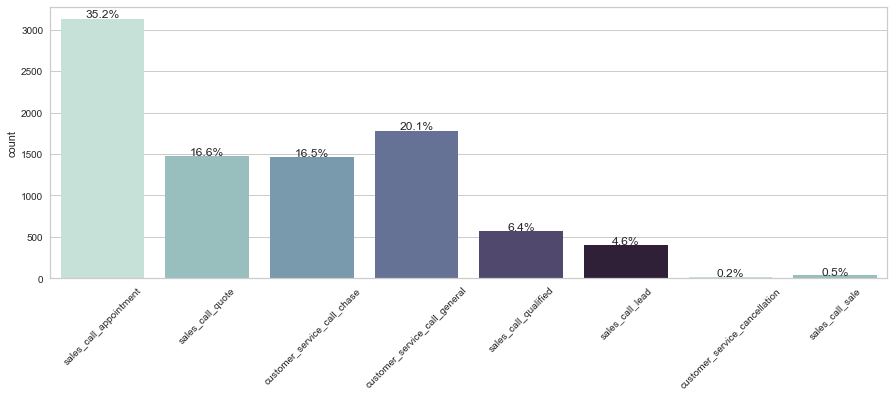

In [44]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x="level_3", data=df_clean, ax=ax, palette=sns.cubehelix_palette(start=.5, rot=-.5))
plt.xticks(rotation=45)
plt.xlabel(None)
total = float(len(df_clean))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() * 1.01
    ax.annotate(percentage, (x, y), ha='center')
plt.show()

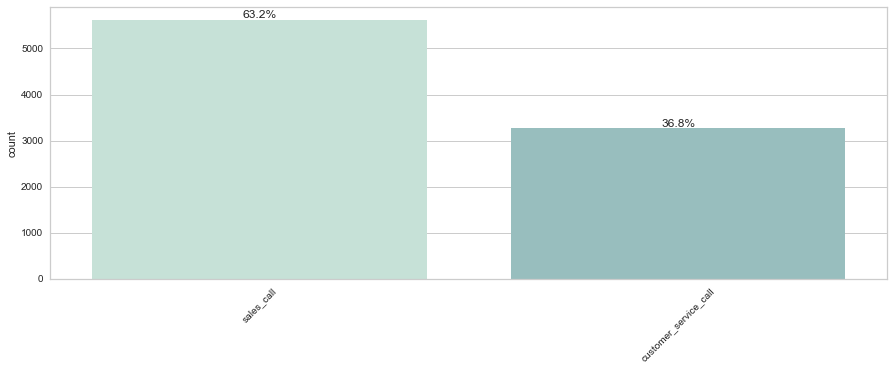

In [66]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x="level_2", data=df_clean, ax=ax, palette=sns.cubehelix_palette(start=.5, rot=-.5))
plt.xticks(rotation=45)
plt.xlabel(None)
total = float(len(df_clean))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() * 1.01
    ax.annotate(percentage, (x, y), ha='center')
plt.show()

# Text Preprocessing

Before feeding any ML model some kind data, textual data has to be properly preprocessed, otherwise it will just "garbage in, garbage out (GIGO)" usually. Text is a specific kind of data and can't be directly fed to most ML models, so we need to extract numerical features from preprocessed text.

 - Text cleaning (stopwords removal, contractions expansion, punctuations removal, etc)
 - Tokenisation
 - (optional) Lematisation and steaming
 - Vectorisation (bag-of-words, word2vec, contextualised embedding, etc)

In [11]:
from textalgo.preprocess.tokenize import word_tokenize

In [93]:
def decontracted(text):
    """Expanding English language contractions"""
    # specific
    text = re.sub(r"won(\'|\’)t", "will not", text)
    text = re.sub(r"can(\'|\’)t", "can not", text)

    # general
    text = re.sub(r"n(\'|\’)t", " not", text)
    text = re.sub(r"(\'|\’)re", " are", text)
    text = re.sub(r"(\'|\’)s", " is", text)
    text = re.sub(r"(\'|\’)d", " would", text)
    text = re.sub(r"(\'|\’)ll", " will", text)
    text = re.sub(r"(\'|\’)l", " will", text)
    text = re.sub(r"(\'|\’)t", " not", text)
    text = re.sub(r"(\'|\’)ve", " have", text)
    text = re.sub(r"(\'|\’)v", " have", text)
    text = re.sub(r"(\'|\’)m", " am", text)
    return text

In [45]:
df_clean['customer_dialogue'] = df_clean['customer_dialogue'].swifter.apply(decontracted)
df_clean['client_dialogue'] = df_clean['client_dialogue'].swifter.apply(decontracted)

Pandas Apply:   0%|          | 0/8878 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8878 [00:00<?, ?it/s]

In [13]:
customer_dialogue_tokens_count = df_clean['customer_dialogue'].swifter.apply(lambda x: len(word_tokenize(x)))
client_dialogue_tokens_count = df_clean['client_dialogue'].swifter.apply(lambda x: len(word_tokenize(x)))
full_dialogue_tokens_count = customer_dialogue_tokens_count + client_dialogue_tokens_count

Pandas Apply:   0%|          | 0/8887 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8887 [00:00<?, ?it/s]

In [14]:
customer_dialogue_utterances_count = [len(re.findall("Customer", t)) for t in df_clean['transcript']]
client_dialogue_utterances_count = [len(re.findall("Client", t)) for t in df_clean['transcript']]
full_dialogue_utterances_count = [i+j for i, j in zip(customer_dialogue_utterances_count, client_dialogue_utterances_count)]

In [15]:
text_stats = pd.DataFrame({
    'Full dialog': [np.mean(full_dialogue_utterances_count).round(2), full_dialogue_tokens_count.mean().round(2)], 
    'Customer': [np.mean(customer_dialogue_utterances_count).round(2), customer_dialogue_tokens_count.mean().round(2)], 
    'Agent': [np.mean(client_dialogue_utterances_count).round(2), client_dialogue_tokens_count.mean().round(2)]
}, index=['#utterances', '#tokens'])
print(tabulate(text_stats, headers=text_stats.columns, tablefmt='psql'))

+-------------+---------------+------------+---------+
|             |   Full dialog |   Customer |   Agent |
|-------------+---------------+------------+---------|
| #utterances |        117.21 |      58.42 |   58.8  |
| #tokens     |        790.24 |     295.77 |  494.48 |
+-------------+---------------+------------+---------+


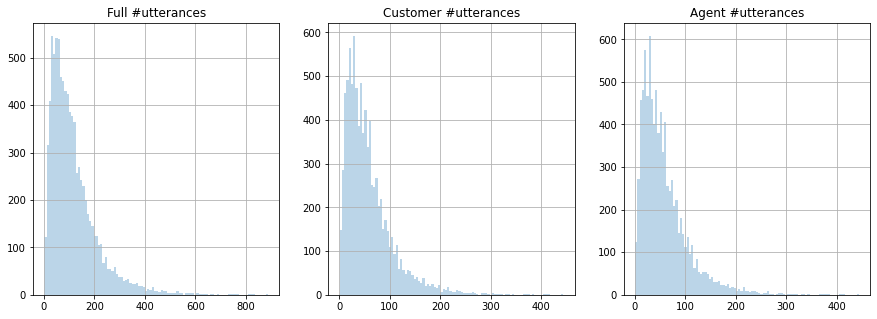

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(full_dialogue_utterances_count, bins=100, label='full', alpha=.3)
axes[0].title.set_text('Full #utterances')
axes[0].grid()

axes[1].hist(customer_dialogue_utterances_count, bins=100, label='customer', alpha=.3)
axes[1].title.set_text('Customer #utterances')
axes[1].grid()

axes[2].hist(client_dialogue_utterances_count, bins=100, label='client', alpha=.3)
axes[2].title.set_text('Agent #utterances')
axes[2].grid()

plt.show()

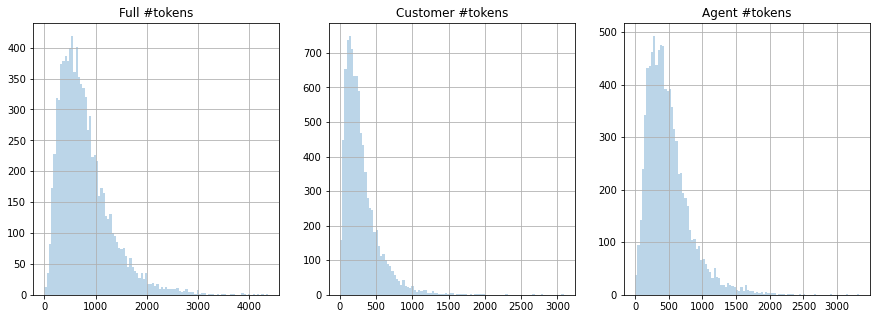

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(full_dialogue_tokens_count, bins=100, label='full', alpha=.3)
axes[0].title.set_text('Full #tokens')
axes[0].grid()

axes[1].hist(customer_dialogue_tokens_count, bins=100, label='customer', alpha=.3)
axes[1].title.set_text('Customer #tokens')
axes[1].grid()

axes[2].hist(client_dialogue_tokens_count, bins=100, label='client', alpha=.3)
axes[2].title.set_text('Agent #tokens')
axes[2].grid()

plt.show()

## Chi Square Feature

In [99]:
import re
from nltk.corpus import stopwords

extension = ['yeah', 'yep', 'yes', 'oh', 'pii', 'uh', 'um', 'â', 'î', 'th', 'a', 'an', 'okay', 'fine']
STOPWORDS = stopwords.words('english') + extension

def remove_stopwords(text, stopwords):
    pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
    text = pattern.sub('', text)
    return text

In [108]:
def tokenizer(text):
    text = decontracted(text)
    text = re.sub('[0-9]', '', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if len(t) > 1]
    return tokens

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectoriser = TfidfVectorizer(
    sublinear_tf=True, 
    min_df=10, 
    norm='l2', 
    encoding='latin-1', 
    ngram_range=(1, 2), 
    stop_words=STOPWORDS, 
    tokenizer=tokenizer
)
features = tfidf_vectoriser.fit_transform(df_clean['customer_dialogue']).toarray()
labels = df_clean.level_3_id
features.shape, labels.shape

((8878, 15126), (8878,))

In [110]:
from sklearn.feature_selection import chi2

N = 5
for level, idx in sorted(level2index.items()):
    features_chi2 = chi2(features, labels == idx)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vectoriser.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("#{}:".format(level))
    print(" - Most correlated unigrams: {}".format(', '.join(unigrams[-N:])))
    print(" - Most correlated bigrams: {}".format(', '.join(bigrams[-N:])))
    print('-' * 100)

#customer_service_call_cancellation:
 - Most correlated unigrams: refund, altogether, culture, cancelling, cancel
 - Most correlated bigrams: right bad, date time, cancel please, cancel booking, like cancel
----------------------------------------------------------------------------------------------------
#customer_service_call_chase:
 - Most correlated unigrams: heard, waiting, reference, cancel, booked
 - Most correlated bigrams: want cancel, need cancel, got reference, heard anything, reference number
----------------------------------------------------------------------------------------------------
#customer_service_call_general:
 - Most correlated unigrams: booked, drainage, blockage, block, blocked
 - Most correlated bigrams: got leak, got problem, blocked toilet, blocked drain, got blocked
----------------------------------------------------------------------------------------------------
#sales_call_appointment:
 - Most correlated unigrams: blockage, block, fine, outside, blo

# Baselines

## Level 2 Classification

### TFIDF-LogRes

In [67]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    df_clean['dialogue'], df_clean['level_2_id'], random_state=914, stratify=df_clean['level_2_id']
)

In [111]:
count_vectoriser = CountVectorizer(
    min_df=10, 
    encoding='latin-1', 
    ngram_range=(1, 2), 
    stop_words=STOPWORDS, 
    tokenizer=tokenizer
)
X_train_counts = count_vectoriser.fit_transform(X_train_2)
tfidf_transformer = TfidfTransformer(sublinear_tf=True, norm='l2')
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
logreg_clf = LogisticRegression(max_iter=1000, warm_start=True, l1_ratio=0.5)
logreg_clf.fit(X_train_tfidf, y_train_2)

LogisticRegression(l1_ratio=0.5, max_iter=1000, warm_start=True)

In [112]:
X_test_counts = count_vectoriser.transform(X_test_2)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [113]:
print('Train set: ')
print('  Accuracy: ', metrics.accuracy_score(y_train_2, logreg_clf.predict(X_train_tfidf)))
print('  F1 score: ', metrics.f1_score(y_train_2, logreg_clf.predict(X_train_tfidf)))
print('Test set: ')
print('  Accuracy: ', metrics.accuracy_score(y_test_2, logreg_clf.predict(X_test_tfidf)))
print('  F1 score: ', metrics.f1_score(y_test_2, logreg_clf.predict(X_test_tfidf)))

Train set: 
  Accuracy:  0.885250826073896
  F1 score:  0.833623693379791
Test set: 
  Accuracy:  0.8175675675675675
  F1 score:  0.735812133072407


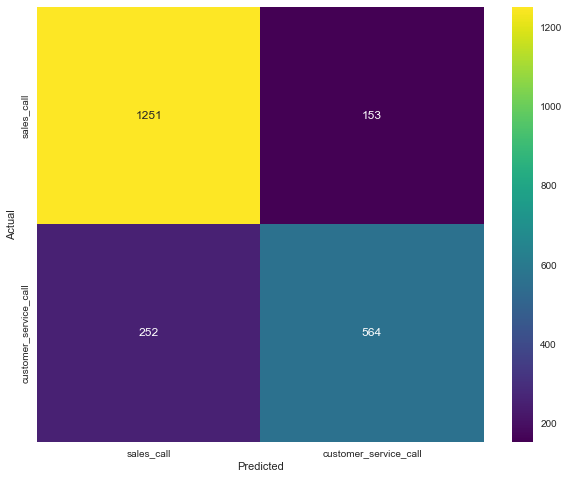

In [114]:
fig, ax = plt.subplots(figsize=(10, 8))
y_pred_2 = logreg_clf.predict(X_test_tfidf)
conf_mat = metrics.confusion_matrix(y_test_2, y_pred_2)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis', 
            xticklabels=['sales_call', 'customer_service_call'], 
            yticklabels=['sales_call', 'customer_service_call'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### TFIDF-XGBoost

In [115]:
xgb_clf = XGBClassifier(n_estimators=200, max_depth=5, n_jobs=4, eval_metric='mlogloss')
xgb_clf.fit(X_train_tfidf, y_train_2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [116]:
print('Train set: ')
print('  Accuracy: ', metrics.accuracy_score(y_train_2, xgb_clf.predict(X_train_tfidf)))
print('  F1 score: ', metrics.f1_score(y_train_2, xgb_clf.predict(X_train_tfidf)))
print('Test set: ')
print('  Accuracy: ', metrics.accuracy_score(y_test_2, xgb_clf.predict(X_test_tfidf)))
print('  F1 score: ', metrics.f1_score(y_test_2, xgb_clf.predict(X_test_tfidf)))

Train set: 
  Accuracy:  1.0
  F1 score:  1.0
Test set: 
  Accuracy:  0.8833333333333333
  F1 score:  0.8412017167381973


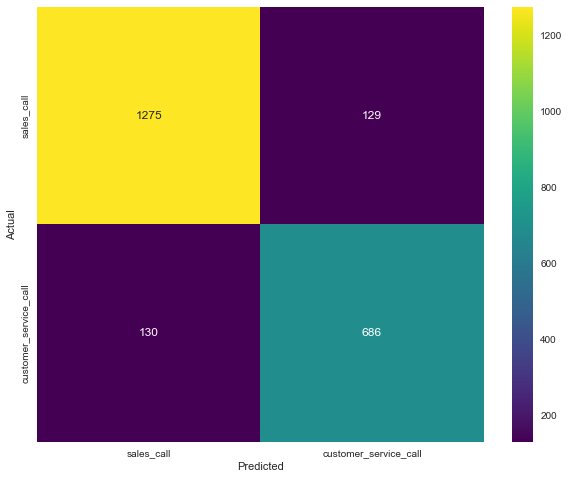

In [117]:
fig, ax = plt.subplots(figsize=(10, 8))
y_pred_2 = xgb_clf.predict(X_test_tfidf)
conf_mat = metrics.confusion_matrix(y_test_2, y_pred_2)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis', 
            xticklabels=['sales_call', 'customer_service_call'], 
            yticklabels=['sales_call', 'customer_service_call'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Level 3 Classification

In [48]:
df_clean['dialogue'] = [d1 + d2 for d1, d2 in zip(df_clean['client_dialogue'], df_clean['customer_dialogue'])]

In [118]:
from sklearn.model_selection import train_test_split

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    df_clean['dialogue'], df_clean['level_3_id'], random_state=914, stratify=df_clean['level_3_id']
)

In [119]:
print(
    f'TR: {len(y_train)}\n'
    f'TT: {len(y_test)}'
)

TR: 6658
TT: 2220


### TFIDF-LogRes

In [120]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression

count_vectoriser = CountVectorizer(
    min_df=10, 
    encoding='latin-1', 
    ngram_range=(1, 2), 
    stop_words=STOPWORDS, 
    tokenizer=tokenizer
)
X_train_counts = count_vectoriser.fit_transform(X_train_3)
tfidf_transformer = TfidfTransformer(sublinear_tf=True, norm='l2')
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
logreg_clf = LogisticRegression(max_iter=1000, warm_start=True, l1_ratio=0.5)
logreg_clf.fit(X_train_tfidf, y_train_3)

LogisticRegression(l1_ratio=0.5, max_iter=1000, warm_start=True)

In [121]:
X_test_counts = count_vectoriser.transform(X_test_3)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [122]:
y_pred_3 = logreg_clf.predict(X_test_tfidf)
print(metrics.classification_report(y_test_3, y_pred_3, target_names=level2index.keys()))

                                    precision    recall  f1-score   support

                   sales_call_lead       0.50      0.03      0.06       102
              sales_call_qualified       0.55      0.08      0.13       143
                  sales_call_quote       0.53      0.38      0.44       368
            sales_call_appointment       0.69      0.88      0.77       781
                   sales_call_sale       0.00      0.00      0.00        10
       customer_service_call_chase       0.57      0.65      0.61       365
     customer_service_call_general       0.52      0.60      0.56       446
customer_service_call_cancellation       0.00      0.00      0.00         5

                          accuracy                           0.61      2220
                         macro avg       0.42      0.33      0.32      2220
                      weighted avg       0.59      0.61      0.57      2220



In [123]:
y_prob_3 = logreg_clf.predict_proba(X_test_tfidf)
print('Top 1 Accuracy: ', metrics.top_k_accuracy_score(y_test_3, y_prob_3, k=1))
print('Top 3 Accuracy: ', metrics.top_k_accuracy_score(y_test_3, y_prob_3, k=3))
print('Top 5 Accuracy: ', metrics.top_k_accuracy_score(y_test_3, y_prob_3, k=5))

Top 1 Accuracy:  0.6063063063063063
Top 3 Accuracy:  0.9076576576576577
Top 5 Accuracy:  0.9815315315315315


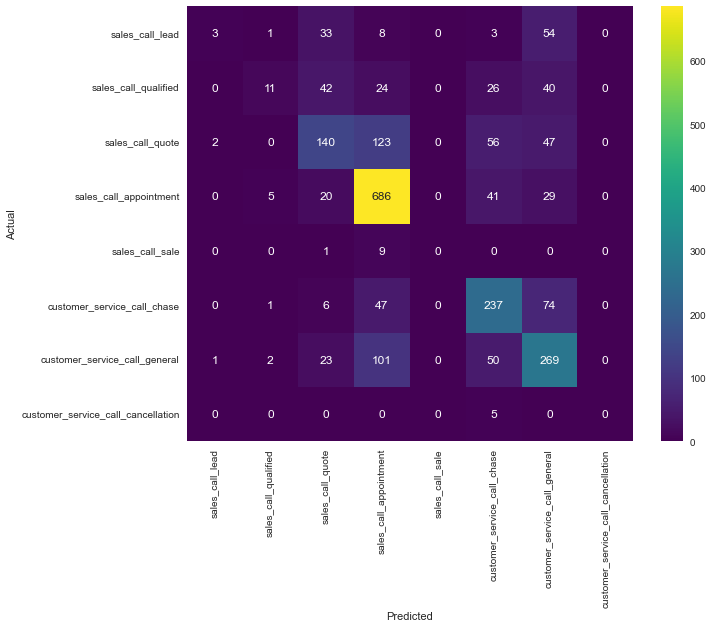

In [124]:
fig, ax = plt.subplots(figsize=(10, 8))
conf_mat = metrics.confusion_matrix(y_test_3, y_pred_3)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis', 
            xticklabels=level2index.keys(), yticklabels=level2index.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Misclassified Samples

In [29]:
df_ = pd.DataFrame({
    'dialogue': X_test_3, 
    'level_3_id': y_test_3, 
    'level_3_pred': y_pred_3
})
df_ = df_.loc[~(df_['level_3_id'] == df_['level_3_pred'])].reset_index(drop=True)
df_['level_3_id'] = df_['level_3_id'].map({v:k for k, v in level2index.items()})
df_['level_3_pred'] = df_['level_3_pred'].map({v:k for k, v in level2index.items()})

In [30]:
# for level in level2index.keys():
#     display(df_.query("level_3_id==@level").reset_index(drop=True))

### TFIDF-XGBoost

In [125]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(n_estimators=400, max_depth=10, n_jobs=4, eval_metric='mlogloss')
xgb_clf.fit(X_train_tfidf, y_train_3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

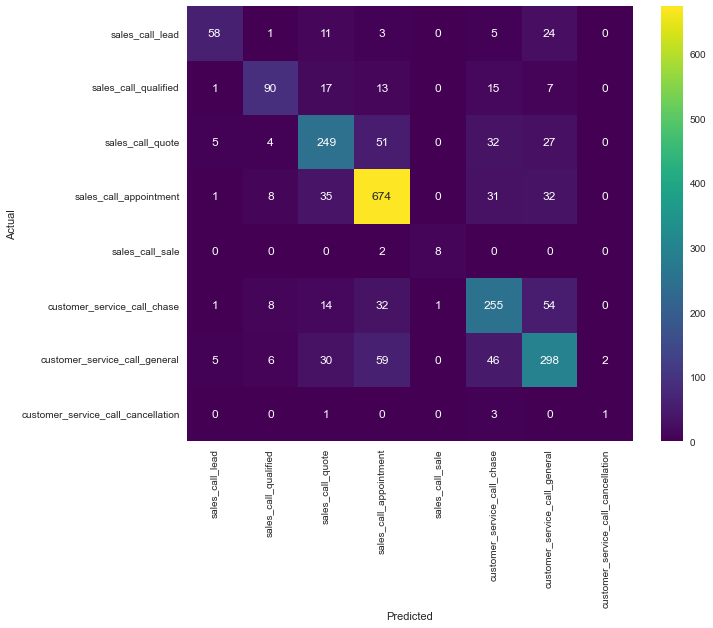

In [126]:
y_pred_3 = xgb_clf.predict(X_test_tfidf)

fig, ax = plt.subplots(figsize=(10, 8))
conf_mat = metrics.confusion_matrix(y_test_3, y_pred_3)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis', 
            xticklabels=level2index.keys(), yticklabels=level2index.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [127]:
y_prob_3 = xgb_clf.predict_proba(X_test_tfidf)
print('Top 1 Accuracy: ', metrics.top_k_accuracy_score(y_test_3, y_prob_3, k=1))
print('Top 3 Accuracy: ', metrics.top_k_accuracy_score(y_test_3, y_prob_3, k=3))
print('Top 5 Accuracy: ', metrics.top_k_accuracy_score(y_test_3, y_prob_3, k=5))

Top 1 Accuracy:  0.7355855855855856
Top 3 Accuracy:  0.9743243243243244
Top 5 Accuracy:  0.995945945945946


![](https://i.stack.imgur.com/tcylh.png)
![](https://i.stack.imgur.com/Nh4Yl.png)

In [128]:
y_pred_3 = xgb_clf.predict(X_test_tfidf)
print('F1 score (micro):    ', metrics.f1_score(y_test_3, y_pred_3, average='micro'))
print('F1 score (macro):    ', metrics.f1_score(y_test_3, y_pred_3, average='macro'))
print('F1 score (weighted): ', metrics.f1_score(y_test_3, y_pred_3, average='weighted'))

F1 score (micro):     0.7355855855855856
F1 score (macro):     0.6657334151921364
F1 score (weighted):  0.7336060350271729


In [129]:
print(metrics.classification_report(y_test_3, y_pred_3, target_names=level2index.keys(), digits=4))

                                    precision    recall  f1-score   support

                   sales_call_lead     0.8169    0.5686    0.6705       102
              sales_call_qualified     0.7692    0.6294    0.6923       143
                  sales_call_quote     0.6975    0.6766    0.6869       368
            sales_call_appointment     0.8082    0.8630    0.8347       781
                   sales_call_sale     0.8889    0.8000    0.8421        10
       customer_service_call_chase     0.6589    0.6986    0.6782       365
     customer_service_call_general     0.6742    0.6682    0.6712       446
customer_service_call_cancellation     0.3333    0.2000    0.2500         5

                          accuracy                         0.7356      2220
                         macro avg     0.7059    0.6381    0.6657      2220
                      weighted avg     0.7355    0.7356    0.7336      2220



### ROC Curve

In [36]:
from yellowbrick.classifier import ROCAUC

def plot_roc_curve(model, X_train, y_train, X_test, y_test, lbl2idx):

    # Creating visualization with the readable labels
    idx2lbl = {v:k for k, v in lbl2idx.items()}
    visualizer = ROCAUC(model, encoder=idx2lbl)
                                        
    # Fitting to the training data first then scoring with the test data
    plt.figure(figsize=(15, 8))
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    
    return visualizer

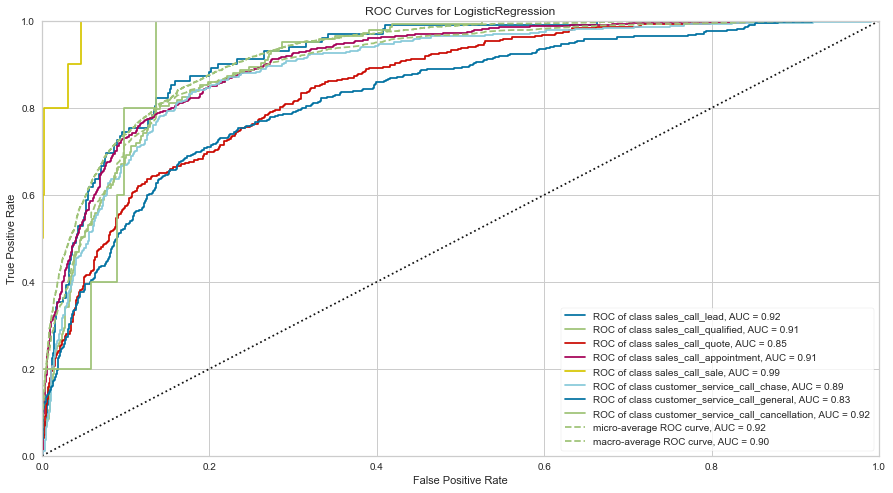

In [130]:
visualizer = plot_roc_curve(logreg_clf, X_train_tfidf, y_train_3, X_test_tfidf, y_test_3, level2index)

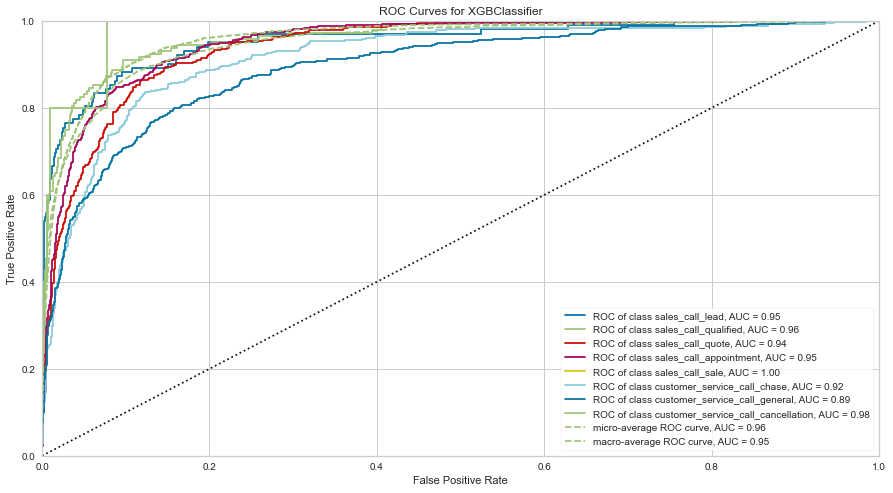

In [131]:
visualizer = plot_roc_curve(xgb_clf, X_train_tfidf, y_train_3, X_test_tfidf, y_test_3, level2index)

### TSNE Visualiser

In [39]:
from yellowbrick.text import TSNEVisualizer

In [40]:
tfidf_vectoriser = TfidfVectorizer(
    sublinear_tf=True, 
    min_df=10, 
    norm='l2', 
    encoding='latin-1', 
    ngram_range=(1, 2), 
    stop_words=STOPWORDS, 
    tokenizer=word_tokenize
)
features = tfidf_vectoriser.fit_transform(df_clean.customer_dialogue).toarray()
labels = df_clean.level_3

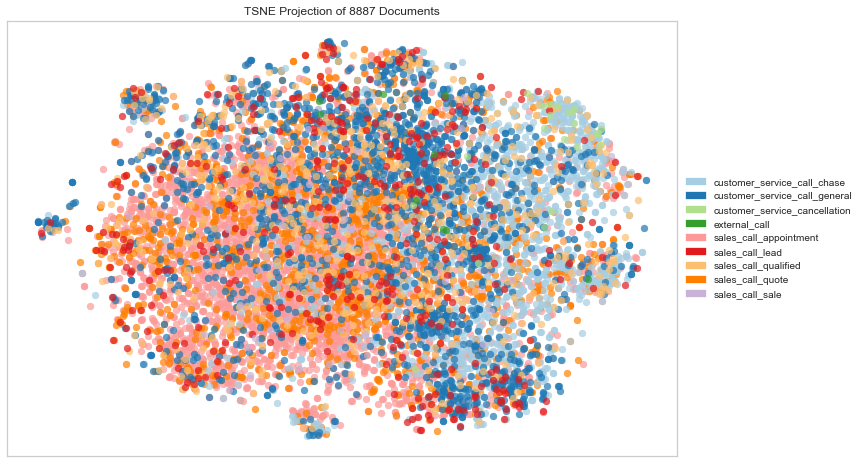

<AxesSubplot:title={'center':'TSNE Projection of 8887 Documents'}>

In [41]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

plt.figure(figsize=(15, 8))
tsne = TSNEVisualizer(colors=sns.color_palette("Paired", 9))
tsne.fit(features, labels)
tsne.show()